In [20]:
import os
import numpy as np
import pandas as pd
import cv2 # OpenCV
from alive_progress import alive_bar
import time
from pathlib import Path
from sklearn.svm import SVC # SVM klasifikator
from skimage.feature import hog as HOG
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt
import pickle
import sys
from tqdm import tqdm
from time import sleep
%matplotlib inline

100%|██████████████████████████████████████████████████████████████████████████████| 2687/2687 [00:32<00:00, 82.09it/s]
Mask on count:  1760
Mask off count:  218
No face count:  709


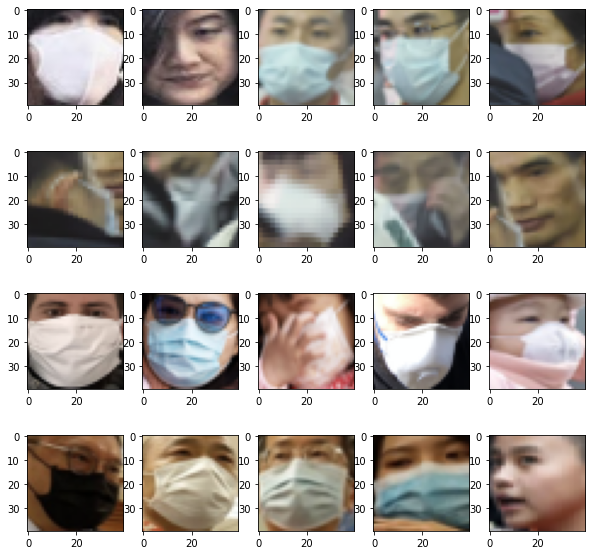

In [34]:
data = pd.read_csv(str(Path().absolute()) + "\\data.csv")

pd.options.mode.chained_assignment = None  # default='warn'

img_base_path = str(Path().absolute()) + "\\archive\\images\\"

i = 0
width = 40
height = 40
dim = (width, height)

fig = plt.figure(figsize=(10, 10))  # width, height in inches

images = []

# define parameters of HOG feature extraction
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3


classifier_mask_on_labels = []
classifier_mask_off_labels = []

computed_mask_on_features = []
computed_mask_off_features = []
computed_no_face_features = []
 
with tqdm(total=len(data['file']), file=sys.stdout) as pbar:
    for fileName in data['file']:
        pbar.update(1)
        image=cv2.imread(img_base_path + fileName)
        [xmin,ymin,xmax,ymax]=data.iloc[i:i+1,0:4].values.tolist()[0]
        cropped_image=image[ymin:ymax,xmin:xmax]

        #gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        
        scaled = cv2.resize(cropped_image, dim, interpolation = cv2.INTER_AREA)
        images.append(scaled)
        
        # fd= feature descriptor
        fd = HOG(scaled, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)

        if data['class'][i] == 0 or data['class'][i] == 1:
            classifier_mask_on_labels.append(1)
            computed_mask_on_features.append(fd)
        elif data['class'][i] == 2:
            classifier_mask_off_labels.append(1)
            computed_mask_off_features.append(fd)
        elif data['class'][i] == -1:
            classifier_mask_on_labels.append(0)
            classifier_mask_off_labels.append(0)
            computed_no_face_features.append(fd)
        i += 1

print('Mask on count: ', len(computed_mask_on_features))
print('Mask off count: ', len(computed_mask_off_features))
print('No face count: ', len(computed_no_face_features))

i = 0
for imageFile in images[0:20]:
    sub = fig.add_subplot(4, 5, i + 1)
    plt.imshow(cv2.cvtColor(imageFile, cv2.COLOR_BGR2RGB))
    i += 1

In [35]:
pos_features = np.array(computed_mask_on_features)
neg_features = np.array(computed_no_face_features)
x = np.vstack((pos_features, neg_features))
y = np.array(classifier_mask_on_labels)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Train shape: ', x_train.shape, y_train.shape)
print('Test shape: ', x_test.shape, y_test.shape)

Train shape:  (1975, 576) (1975,)
Test shape:  (494, 576) (494,)


In [37]:
"""
mask_off_classifier = SVC(kernel = 'rbf',gamma='scale', probability=True)
mask_off_classifier.fit(x_train, y_train)
y_train_pred = mask_off_classifier.predict(x_train)
y_test_pred = mask_off_classifier.predict(x_test)
print("No Mask Detection:")
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))
"""

mask_on_classifier = SVC(kernel = 'rbf',gamma='scale', probability=True)
mask_on_classifier.fit(x_train, y_train)
y_train_pred = mask_on_classifier.predict(x_train)
y_test_pred = mask_on_classifier.predict(x_test)
print("Mask Detection:")
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))

Mask Detection:
Train accuracy:  0.9939240506329113
Validation accuracy:  0.9696356275303644


In [38]:
#0.969 40x40

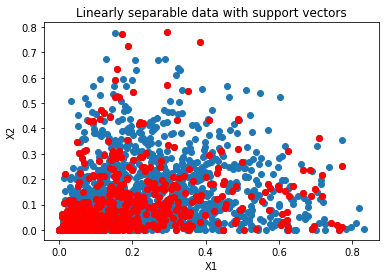

In [39]:
# Get support vectors themselves
support_vectors = mask_on_classifier.support_vectors_

# Visualize support vectors
plt.scatter(x_train[:,0], x_train[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [43]:
"""
i = 0
for imageFile in images[0:x_train.shape[0]]:
    if y_train[i] == y_train_pred[i]:
        features = HOG(imageFile, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True).reshape(1, -1)
        plt.figure()
        plt.imshow(cv2.cvtColor(imageFile, cv2.COLOR_BGR2RGB))
        plt.title("indx " + str(i + 2) + " labeled " + str(y_train[i]) + " prediction " + str(y_train_pred[i]) + " - "+str(mask_on_classifier.predict_proba(features)[0]))
    i+=1
"""

'\ni = 0\nfor imageFile in images[0:x_train.shape[0]]:\n    if y_train[i] == y_train_pred[i]:\n        features = HOG(imageFile, orientations, pixels_per_cell, cells_per_block, block_norm=\'L2\', feature_vector=True).reshape(1, -1)\n        plt.figure()\n        plt.imshow(cv2.cvtColor(imageFile, cv2.COLOR_BGR2RGB))\n        plt.title("indx " + str(i + 2) + " labeled " + str(y_train[i]) + " prediction " + str(y_train_pred[i]) + " - "+str(mask_on_classifier.predict_proba(features)[0]))\n    i+=1\n'

In [44]:
pickle.dump(mask_on_classifier, open('mask_on_classifier.sav', 'wb'))